In [14]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 28.0
xtick = matplotlib.ticker.FuncFormatter(lambda x, pos: '%.1f'%(x*10**3))
from scipy.stats import norm, chi2
import numpy as np
import os.path
import classyVS as vs
reload(vs);

### Set all parameters, use Micro-X ###
mx_params = vs.micro_x_params.copy()
mx_lon = np.array([-105., -65., -25., 25., 65., 105.])
mx_lat = 25.
mxvs = vs.velocitySpectroscopy(halo=374, instrument_params=mx_params, verbose=False)
data_an = vs.readVSData(374, 'analytic')
# data_fill = vs.readVSData(h, 'fill')

prefac = 1.44630429319e-06


In [13]:
print mx_params['sigma_energy']*3.55e3

1.2921824533


 /lustre/ki/pfs/dmpowel1/DMVS_runs/halo881.1.fit not found
 /lustre/ki/pfs/dmpowel1/DMVS_runs/halo469.1.fit not found
 /lustre/ki/pfs/dmpowel1/DMVS_runs/halo641.1.fit not found
 /lustre/ki/pfs/dmpowel1/DMVS_runs/halo9749.1.fit not found


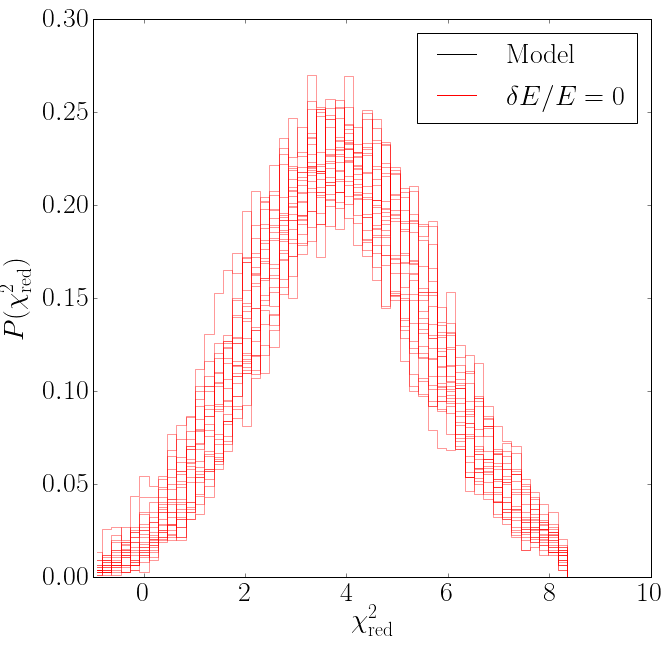

In [107]:
###### histogram of chi2 values with no plot ########
fsz=10
fig, ax = plt.subplots(1, 1, figsize=(fsz, fsz))
hrange = (-1, 10)
nbins=60
binw=(hrange[1]-hrange[0])/nbins

fud = 1
npoint = 6
dof = 6
for halo in vs.mws.allHaloes:
    fname = '/lustre/ki/pfs/dmpowel1/DMVS_runs/halo%d.%d.fit' % (halo, fud)
    if not os.path.isfile(fname):
        print '', fname, 'not found'
        continue
    with open(fname, 'rb') as f:
        nsamp = np.fromfile(f, dtype=np.int32, count=1)[0]
        allpar = np.fromfile(f, dtype=np.float64, count=nsamp*npoint*4).reshape((nsamp, npoint, 4))
        allcov = np.fromfile(f, dtype=np.float64, count=nsamp*npoint*4*4).reshape((nsamp, npoint, 4, 4))
        assert nsamp == np.fromfile(f, dtype=np.int32, count=1)[0]
        
        data_an = vs.readVSData(halo, 'analytic')
        mu_an = data_an['centroid'][::2]  #[data_an['l']==mx_lon]


    # get the chi^2 for the model and the null version
    chi2_mod = np.sum((allpar[:,:,0]-mu_an)**2/allcov[:,:,0,0], axis=1)
    chi2_null = np.sum(allpar[:,:,0]**2/allcov[:,:,0,0], axis=1)

#     hist_mod, bine = np.histogram(chi2_mod, range=hrange, bins=60, density=True)
#     hist_null, bine = np.histogram(chi2_null, range=hrange, bins=60, density=True)
    
#     hist_mod, bine = np.histogram(chi2_mod**0.5, range=hrange, bins=60, density=True)
#     hist_null, bine = np.histogram(chi2_null**0.5, range=hrange, bins=60, density=True)

#     hist_mod, bine = np.histogram(norm.ppf(chi2.cdf(chi2_mod, dof)), range=hrange, bins=60, density=True)
    hist_null, bine = np.histogram(norm.ppf(chi2.cdf(chi2_null, dof)), range=hrange, bins=60, density=True)
    binc = 0.5*(bine[1:]+bine[:-1])
    
#     ax.plot(binc, hist_mod, 'k-', drawstyle='steps-mid', alpha=0.4)
    ax.plot(binc, hist_null, 'r-', drawstyle='steps-mid', alpha=0.4)

ax.set_ylabel(r'$P(\chi^2_\mathrm{red})$')
ax.set_xlabel(r'$\chi^2_\mathrm{red}$')
ax.set_xlim(*hrange)

# ax.plot(binc, chi2.pdf(binc*dof, dof))
ax.plot([-1],[0], 'k-', label='Model')
ax.plot([-1],[0], 'r-', label='$\delta E/E = 0$')
ax.legend(fontsize=28)

l = -105.0 , n_s, n_b, n_tot = 182.499709028 387.500332526 570.000041554
l = -65.0 , n_s, n_b, n_tot = 305.803505719 362.1965265 668.000032219
l = -25.0 , n_s, n_b, n_tot = 584.741145055 364.25879618 948.999941235
l = 25.0 , n_s, n_b, n_tot = 654.868174257 408.131880918 1063.00005518
l = 65.0 , n_s, n_b, n_tot = 344.593644506 426.406338065 770.999982571
l = 105.0 , n_s, n_b, n_tot = 186.393364562 372.606642868 559.000007429
chi^2_model = [ 1.61727983] dof = 4 p = [ 0.16674654] sigma = [-0.96710191]
chi^2_null = 199.674721863 dof = 6 p = 0.0 sigma = -inf


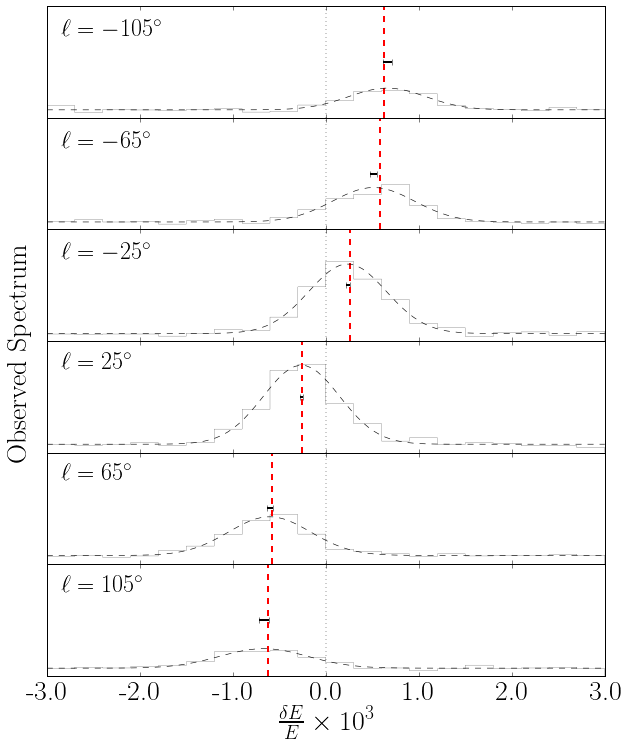

In [9]:
###### comparison of dF/dE for both the N-body and analytic models ########
fig, axes = plt.subplots(len(mx_lon), 1, figsize=(10, 12), sharex=True, sharey=True) # scale x-axis by 10**3
fig.subplots_adjust(hspace=0)
nbins = 20
hrange = mx_params['energy_range']
binw=(hrange[1]-hrange[0])/nbins
xp = np.linspace(*hrange, num=100)
fud = 100
yr = 9e3*binw*fud
for ax in axes:
    ax.xaxis.set_major_formatter(xtick)    
    ax.set_yticks([])
    ax.set_xlim(*hrange);
    ax.set_ylim(0.0, yr);

# make the distributions and negative log-likelihood
# par: (mu_line, sigma_line, n_sig, n_bg)
sig_instr = mx_params['sigma_energy']
energy_range = mx_params['energy_range']
def pdf(x, par):
    # enforce some params > 0
    mu = par[0]; sig = abs(par[1]); ns = abs(par[2]); nb = abs(par[3])
    gauss = norm.pdf(x, loc=mu, scale=(sig**2+sig_instr**2)**0.5)
    unif = 1.0/(energy_range[1]-energy_range[0])
    prob = ns*gauss+nb*unif
    return prob

mxvs.rotateHaloInPlace()

# sample photons for the six pointings
# phot = mxvs.samplePhotonsFromNBody(lon=mx_lon, lat=mx_lat, fudge=fud)

chi2_mod = 0.0
chi2_null = 0.0
for lon, ax in zip(mx_lon, axes):
    
    phot = mxvs.samplePhotonsFromNBody(lon=lon, lat=mx_lat, fudge=fud)
    cent_an = data_an['centroid'][data_an['l']==lon]
    
    # extended maximum-likelihood fit on the photons
    par = np.array([-220./3.0e5*np.sin(lon*np.pi/180.)*np.cos(25.0*np.pi/180.), \
                    5.0e-4, 5.0*fud, 1.0*fud]) # initial guess
    par, cov = mxvs.fitLinePlusBG(phot, par0=par)

    print 'l =', lon, ', n_s, n_b, n_tot =', par[2], par[3], (par[2]+par[3])

    chi2_null += par[0]**2/cov[0,0]
    chi2_mod += (par[0]-cent_an)**2/cov[0,0]
    
    ax.errorbar(par[0], yr*0.5, xerr=cov[0,0]**0.5, lw=2, color='black')
    ax.plot([cent_an, cent_an],[0.,yr], 'r--', lw=2);
    
#     ax.plot([par[0],par[0]],[0.,yr], 'r:', lw=3);
#     ax.plot([vslcb, vslcb],[0.,yr], 'r:', lw=3);\

    # plot histogram along with the models
    ax.hist(phot, bins=nbins, range=hrange, histtype='step', lw=0.2, color='black')
    ax.plot(xp, binw*pdf(xp, par), 'k--', lw=0.6)
    ax.plot([0.,0.],[0.,yr], 'k:', lw=0.4);
    ax.text(hrange[0]*0.95, yr*0.9, '$\ell=%.0f^\circ$'%lon, va='top', fontsize=24);
    
# print sig2**0.5
    
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
fig.text(0.07, 0.5, r'Observed Spectrum', va='center', rotation='vertical')
# ax.legend(loc='upper right', fontsize=28)
# fig.savefig('../img/dfde_pointings.png', bbox_inches='tight')

# do chi^2
dof = len(mx_lon)-2
p = 1-chi2.cdf(chi2_mod, dof)
sigma = norm.ppf(p)
print 'chi^2_model =', chi2_mod/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma
dof = len(mx_lon)
p = 1-chi2.cdf(chi2_null, dof)
sigma = norm.ppf(p)
print 'chi^2_null =', chi2_null/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma

In [ ]:
plt.hist(chi2_mod, bins=64, histtype='step', lw=0.2, color='black');
xp = np.linspace(0,45,100)
binw = xp[1]-xp[0]
plt.plot(nsamp*binw*chi2.pdf(xp, 4))

In [ ]:
plt.hist(chi2_null, bins=64, histtype='step', lw=0.2, color='black');

In [ ]:
###### comparison of dF/dE for both the N-body and analytic models ########
reload(vs);
obsinds = range(0,11,2) # micro-X uses half of the saved data
fig, axes = plt.subplots(len(obsinds), 1, figsize=(10, 12), sharex=True, sharey=True) # scale x-axis by 10**3
fig.subplots_adjust(hspace=0)
binw = 0.25/(3.5e3) # keV
nbins = 2*int(3.0e-3/binw)
hrange = (-nbins/2*binw, nbins/2*binw)
xp = np.linspace(*hrange, num=100)
fud = 200
yr = 9e3*binw*fud
for ax in axes:
    ax.xaxis.set_major_formatter(xtick)    
    ax.set_yticks([])
    ax.set_xlim(*hrange);
    ax.set_ylim(0.0, yr);
    
# MC sample photons directly from the N-body particles
photons = vs.samplePhotonsFromNBody(pos, vel, partmass, lon=mx_lon, \
                fudge=fud, **mx_params)
# print photons
    
# make the distributions and negative log-likelihood
# par: (mu_line, sigma_line, n_sig, n_bg)
sig_instr = mx_params['sigma_energy']
energy_range = mx_params['energy_range']
def pdf(x, par):
    # enforce some params > 0
    mu = par[0]; sig = abs(par[1]); ns = abs(par[2]); nb = abs(par[3])
    gauss = norm.pdf(x, loc=mu, scale=(sig**2+sig_instr**2)**0.5)
    unif = 1.0/(energy_range[1]-energy_range[0])
    prob = ns*gauss+nb*unif
    return prob

chi2_mod = 0.0
chi2_null = 0.0

for lon, ax in zip(mx_lon, axes):
    
    phot = photons[1][photons[0]==lon]
    cent_an = data_an['centroid'][data_an['l']==lon]
    
#     print phot
    
    # extended maximum-likelihood fit on the photons
    par = np.array([-220./3.0e5*np.sin(lon*np.pi/180.)*np.cos(25.0*np.pi/180.), \
                    5.0e-4, 5.0*fud, 1.0*fud]) # initial guess
    par, cov = vs.fitLinePlusBG(phot, par0=par, **mx_params)
#     print par


    print 'l =', lon, ', n_s, n_b, n_tot =', par[2], par[3], (par[2]+par[3])

    chi2_null += par[0]**2/cov[0,0]
    chi2_mod += (par[0]-cent_an)**2/cov[0,0]
    
    ax.errorbar(par[0], yr*0.7, xerr=cov[0,0]**0.5, lw=2, color='black')
    ax.plot([cent_an, cent_an],[0.,yr], 'r-', lw=3);
    
#     ax.plot([par[0],par[0]],[0.,yr], 'r:', lw=3);
#     ax.plot([vslcb, vslcb],[0.,yr], 'r:', lw=3);\

    # plot histogram along with the models
    ax.hist(phot, bins=nbins, histtype='step', lw=0.2, color='black')
    ax.plot(xp, binw*pdf(xp, par), 'k--', lw=0.6)
    ax.plot([0.,0.],[0.,yr], 'k:', lw=0.4);
    ax.text(hrange[0]*0.95, yr*0.9, '$\ell=%.0f^\circ$'%lon, va='top', fontsize=24);
    
# print sig2**0.5
    
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
fig.text(0.07, 0.5, r'Observed Spectrum', va='center', rotation='vertical')
# ax.legend(loc='upper right', fontsize=28)
# fig.savefig('../img/dfde_pointings.png', bbox_inches='tight')

# do chi^2
dof = len(mx_lon)-2
p = 1-chi2.cdf(chi2_mod, dof)
sigma = norm.ppf(p)
print 'chi^2_model =', chi2_mod/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma
dof = len(mx_lon)
p = 1-chi2.cdf(chi2_null, dof)
sigma = norm.ppf(p)
print 'chi^2_null =', chi2_null/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma

In [ ]:
###### comparison of dF/dE for both the N-body and analytic models ########
reload(vs);
fig, axes = plt.subplots(len(obsinds), 1, figsize=(10, 12), sharex=True, sharey=True) # scale x-axis by 10**3
fig.subplots_adjust(hspace=0)
binw = 0.5/(3.5e3) # keV
pran = 3.0e-3
nbins = 2*int(pran/binw)
hrange = (-nbins/2*binw, nbins/2*binw)
xp = np.linspace(*hrange, num=100)
fud = 1
yr = 9e3*binw*fud
for ax in axes:
    ax.xaxis.set_major_formatter(xtick)    
    ax.set_yticks([])
    ax.set_xlim(*hrange);
    ax.set_ylim(0.0, yr);
    
sig_instr = mx_params['sigma_energy']
    
# make the distributions and negative log-likelihood
def pdf(x, mu, sigma, ns, nb):
    return ns*norm.pdf(x, loc=mu, scale=(sigma**2+sig_instr**2)**0.5) \
                +nb*1.0/(hrange[1]-hrange[0])
    
# par: (mu_line[all], sigma_line[all], n_sig[all], n_bg)
def nll(par, *args):
    data = args[0]
    npointings = args[1]
    allmu = par[0:npointings]
    allsig = abs(par[npointings:2*npointings])
    allns = abs(par[2*npointings:3*npointings])
    nb = abs(par[3*npointings])
    
    nll = 0.0
    for i in xrange(npointings):
        prob = pdf(data[1][data[0]==mx_lon[i]],allmu[i],allsig[i],allns[i],nb)
        nll += -np.sum(np.log(prob)) + (allns[i]+nb)
    
    return nll



# MC sample photons directly from the N-body particles
# extended maximum-likelihood fit on the photons
# joint analysis for all photons!
photons, _ = vs.samplePhotonsFromNBody(pos, vel, partmass, lon=mx_lon, \
                fudge=fud, do_bg=True, bg_range=hrange, **mx_params)
npoint = mx_lon.size

# set up smart initial guesses
par = np.empty(3*npoint+1)
par[0:npoint] = -220/3.0e5*np.sin(np.pi/180*mx_lon) # mu
par[npoint:2*npoint] = 5.0e-4 # sigma
par[2*npoint:3*npoint] = 5*fud # ns
par[3*npoint] = 1*fud # ns

# par = fmin_cobyla(nll, par, [], args=(photons, npoint), disp=True, maxfun=100000)
par = fmin(nll, par, args=(photons, npoint), disp=True, maxiter=100000, maxfun=100000)
# par = fmin_slsqp(nll, par, args=(photons, npoint), disp=True, iter=100000)
# llr = minimize(nll, par, args=(photons, npoint), method='COBYLA')
# par=llr.x
par[npoint:] *= np.sign(par[npoint:])

# print np.sum(par[2*npoint:3*npoint])+par[3*npoint]

chi2_mod = 0.0
chi2_null = 0.0
for i, (lon, ax) in enumerate(zip(mx_lon, axes)):

    print 'l =', lon, ', n_s, n_b, n_tot =', \
        par[2*npoint+i], par[3*npoint], (par[2*npoint+i]+par[3*npoint])
        
    # TODO: correctly evaluate the joint error matrix!!!
    cent_an = data_an['centroid'][data_an['l']==lon]
    thispar = np.array([par[i], par[npoint+i], par[2*npoint+i], par[3*npoint]])
#     print thispar
#     cov = errors(thispar)
#     ax.errorbar(thispar[0], yr*0.7, xerr=cov[0,0]**0.5, lw=2, color='black')
    ax.plot([cent_an, cent_an],[0.,yr], 'r-', lw=3);\
#     chi2_null += thispar[0]**2/cov[0,0]
#     chi2_mod += (thispar[0]-cent_an)**2/cov[0,0]

    
    ax.plot(xp, binw*pdf(xp, par[i], par[npoint+i], \
                par[2*npoint+i], par[3*npoint]), 'k--', lw=0.6)
    
    phot = photons[1][photons[0]==lon]
    
    # plot histogram along with the models
    ax.hist(phot, bins=nbins, range=hrange, histtype='step', lw=0.6, color='black')
    ax.plot([0.,0.],[0.,yr], 'k:', lw=0.4);
    ax.text(hrange[0]*0.95, yr*0.9, '$\ell=%.0f^\circ$'%lon, va='top', fontsize=24);
    
ax.set_xlabel(r'$\frac{\delta E}{E} \times 10^3$')
fig.text(0.07, 0.5, r'Observed Spectrum', va='center', rotation='vertical')
# ax.legend(loc='upper right', fontsize=28)

# fig.savefig('../img/dfde_pointings.png', bbox_inches='tight')
# ''';
# do chi^2
dof = len(mx_lon)-2
p = 1-chi2.cdf(chi2_mod, dof)
sigma = norm.ppf(p)
print 'chi^2_model =', chi2_mod/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma
dof = len(mx_lon)
p = 1-chi2.cdf(chi2_null, dof)
sigma = norm.ppf(p)
print 'chi^2_null =', chi2_null/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma

In [ ]:


# test extended maximum likelihood with sum of gaussians!
data = np.append(np.random.normal(loc=-1.5, scale=0.1, size=np.random.poisson(lam=500)),\
        np.random.normal(loc=1.0, scale=1.0, size=np.random.poisson(lam=900)))

hrange = (-3., 3.)
hist, bine = np.histogram(data, bins=100, range=hrange)
binc = 0.5*(bine[1:]+bine[:-1])

# extended maximum likelihood
def nll(par, data):
    # par: [n0, mu0, sig0, n1, mu1, sig1]
    
    prob = par[0]*norm.pdf(data, loc=par[1], scale=par[2])\
                +par[3]*norm.pdf(data, loc=par[4], scale=par[5])
        
    return -np.sum(np.log(prob)) + (par[0]+par[3])

llres = minimize(nll, [100, -1., 1., 100, 1., 1.], args=data, method='Nelder-Mead')
print llres

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(binc, hist, 'k-', drawstyle='steps-mid')
xp=np.linspace(*hrange, num=100)

# probability in each bin
fit = (llres.x[0]*norm.cdf(bine, loc=llres.x[1], scale=llres.x[2])\
                 +llres.x[3]*norm.cdf(bine, loc=llres.x[4], scale=llres.x[5]))
fit = fit[1:]-fit[:-1]
ax.plot(binc, fit, 'k--')

In [ ]:
reload(vs);
# np.random.seed(10291989)

# sample the N-body distribution and get a chi^2 for this sampling
# use non-overlapping FOVs
an_lon = an['l'][::2] 
an_centroid = an['centroid'][::2] 
print ' N-body sampling of photons'
photons, line = vs.samplePhotonsFromNBody(pos, vel, partmass, fudge=1, lon=an_lon, **mx_params)

# get chi^2 for the model fit
dof = len(an_lon)-2
X2 = np.sum(((an_centroid-line[1])/line[2])**2)
p = 1-chi2.cdf(X2, dof)
sigma = norm.ppf(p)
print 'chi^2_model =', X2/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma

# get chi^2 for the null case
dof = len(an_lon)
X2 = np.sum((line[1]/line[2])**2)
p = 1-chi2.cdf(X2, dof)
sigma = norm.ppf(p)
print 'chi^2_null =', X2/dof, 'dof =', dof, 'p =', p, 'sigma =', sigma

# plot the photons and their lines
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(photons[0]+1.0, photons[1]*10**3, lw=0, s=10, c='black', label='$\gamma$')
ax.errorbar(line[0]-1.0, line[1]*10**3, yerr=line[2]*10**3, c='blue', fmt='.', markersize=10, label='Line')

# plot the model
flon = fill['l']
cent = fill['centroid']*10**3
plus = cent + fill['sigma_centroid']*10**3
minus = cent - fill['sigma_centroid']*10**3
ax.fill_between(flon, minus, plus, facecolor='black', alpha=0.05, label='Model')
ax.plot(flon, cent, 'k-', alpha=0.4)
ax.plot([-120, 120], [0,0], 'k-', lw=0.4)

# ax.plot(flon, -0.65*np.sin(flon*np.pi/180), 'r-', alpha=1.0)

# frills
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'$\ell$ ($^{\circ}$)')
ax.set_xlim(-120., 120.)
ax.invert_xaxis()
# ax.set_ylim(-1.2, 1.2)
ax.set_ylim(-1.5, 1.5)
ax.grid(True)

ax.legend(loc='upper left', fontsize=28)

# fig.savefig('../img/de_vs_l_800.png', bbox_inches='tight')
# fig.savefig('../img/de_vs_l_filled.png', bbox_inches='tight')

In [ ]:
reload(vs);
# np.random.seed(10291989)

for h in [374]: #mws.allHaloes:
    
    an = vs.readVSData(h, 'analytic')
    fill = vs.readVSData(h, 'fill')
    nb = vs.readVSData(h, 'nbody')
#     nb = vs.spectroscopy(mode='nbody', pos=pos, vel=vel, mass=partmass, lon=fill['l'], **mx_params)
    
    ell = nb['l'][::2]
    cent = nb['centroid'][::2]
    sig = nb['sigma_centroid'][::2]

    # plot the photons and their lines
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.errorbar(ell, cent*10**3, yerr=sig*10**3, \
                c='blue', fmt='.', markersize=10, label='N-body')
    
    dof_model = len(ell)-2 # lose 2 dof for the fitted NFW parameters
    
    dof_null = len(ell)
    nsigma_null = cent/sig
    chi2_null = np.sum(nsigma_null**2)
    sigma_null = chi2_null**0.5
    print 'nsigma =', nsigma_null
    print 'sigma_null', sigma_null
    print 'chi^2_null (red) =', chi2_null/dof_null
    print chi2.cdf(chi2_null, dof_null)

# plot the model
flon = fill['l']
cent = fill['centroid']*10**3
# plus = cent + fill['sigma_centroid']*10**3
# minus = cent - fill['sigma_centroid']*10**3
# # ax.fill_between(flon, minus, plus, facecolor='black', alpha=0.08, label='Model')
ax.plot(flon, cent, 'k-', label='Analytic NFW')
ax.plot([-120, 120], [0,0], 'k-', lw=0.4)

vcosb = -220/3.0e5*np.cos(25./180.*np.pi)*10**3
ax.plot(flon, vcosb*np.sin(flon*np.pi/180), 'r-', label=r'$(v_\odot/c)\sin(\ell)\cos(b)$')

# # ax.plot(flon, -0.65*np.sin(flon*np.pi/180), 'r-', alpha=1.0)

# frills
ax.set_ylabel(r'$\frac{\delta E}{E} \times 10^3$')
ax.set_xlabel(r'$\ell$ ($^{\circ}$)')
ax.set_xlim(-120., 120.)
ax.invert_xaxis()
ax.set_ylim(-1.2, 1.2)
# ax.set_ylim(-1.5, 1.5)
ax.grid(True)

ax.legend(loc='upper left', fontsize=28)

# fig.savefig('../img/de_vs_l_800.png', bbox_inches='tight')
# fig.savefig('../img/de_vs_l_filled.png', bbox_inches='tight')

In [ ]:
reload(vs);
nreal = 10
mx_lon = np.array([-105., -65., -25., 25., 65., 105.])
allchi2 = np.empty(nreal)

for i in xrange(nreal):

    photons, line = vs.samplePhotonsFromNBody(pos, vel, partmass, lon=mx_lon, **mx_params)

#     x2 = ((an['centroid']-line[1])/line[2])**2
#     x2 = x2[~np.isnan(x2)]
    
#     # reduced chi^2
#     allchi2[i] = np.sum(x2)/len(x2)
    
    sigma = np.sum((line[1]/line[2])**2)**0.5
    print sigma

# print allchi2

# histogram the bins
hist, bins = np.histogram(allchi2, bins=64, range=(0, 3), density=True)
bins = 0.5*(bins[1:]+bins[:-1]) # rescale bins to be in terms of fractional energy shift

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(bins, hist, '-', drawstyle='steps-mid')
ax.set_xlabel(r'$\chi^2_\mathrm{red}$')
ax.set_ylabel(r'$P(\chi^2_\mathrm{red})$')

In [ ]:
print allchi2/dof

In [ ]:
# load and do chi2
haloes = vsdata.haloesWithVSData
for i, h in enumerate(haloes):
    print 'Halo %d of %d:' % (i+1, len(haloes)),
    nb = vsdata.readVSData(h, 'nbody')
    an = vsdata.readVSData(h, 'analytic')
    
    # the chi-square value for this fit
    # No weights -- already taken care of in Ns**-0.5 in the uncertainties!
#     x2 = np.average((nb['cen']-an['cen'])**2/(nb['sig']**2+an['sig']**2), weights=None)
    x2 = np.sum((nb['centroid']-an['centroid'])**2/(nb['sigma_centroid']**2+an['sigma_centroid']**2))
    dof = len(nb['l'])
    p = chi2.cdf(x2, dof)
    
#     # TODO: treating DOF??


    print 'Chi^2 =', x2, 'p = ', p, 'sigma = ', norm.ppf(1.-p)

In [ ]:
'''
# Code to test uniformity of 3d rotation sampling.
# Looks good!
reload(vs);
from mpl_toolkits.mplot3d import Axes3D
fig = matplotlib.pyplot.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection = '3d')

whisk = np.array([[-0.02, 0.0, 1.0], [0.02, 0.0, 1.0]])

for i in xrange(500):
    rot = vs.generateRotationMatrix()
    w = np.dot(whisk, rot)
    ax.plot(w[:,0], w[:,1], w[:,2], color = 'b');

ax.set_xlim([-1.1, 1.1]);
ax.set_ylim([-1.1, 1.1]);
ax.set_zlim([-1.1, 1.1]);
''';